# Segmentasi Lesi Benign(Jinak) pada Citra USG Payudara dengan Metode U-Net dan K-Means 

Imports

In [2]:
# pip install numpy opencv-python pillow albumentations scikit-learn matplotlib tensorflow keras

# Standard Libraries
import os
from glob import glob

# Data Processing & Augmentation
import cv2
import numpy as np
from PIL import Image
import albumentations as A
from sklearn.model_selection import train_test_split

# Data Visualization
import matplotlib.pyplot as plt

# Machine Learning & Metrics
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU, Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam


# Data Loading and Preparation

Exploring data

In [2]:
paths = glob('Dataset_BUSI_with_GT/benign/*')

print(f'\033[92m')
print(f"'benign' class has {len([i for i in paths if 'benign' in i and 'mask' not in i])} images and {len([i for i in paths if 'benign' in i and 'mask' in i])} masks.")


'benign' class has 437 images and 454 masks.


In [3]:
# Some images have 2 or more masks. Combine them into one image.
sorted(glob('Dataset_BUSI_with_GT/benign/*'))[4:7]

['Dataset_BUSI_with_GT/benign\\benign (100).png',
 'Dataset_BUSI_with_GT/benign\\benign (100)_mask.png',
 'Dataset_BUSI_with_GT/benign\\benign (100)_mask_1.png']

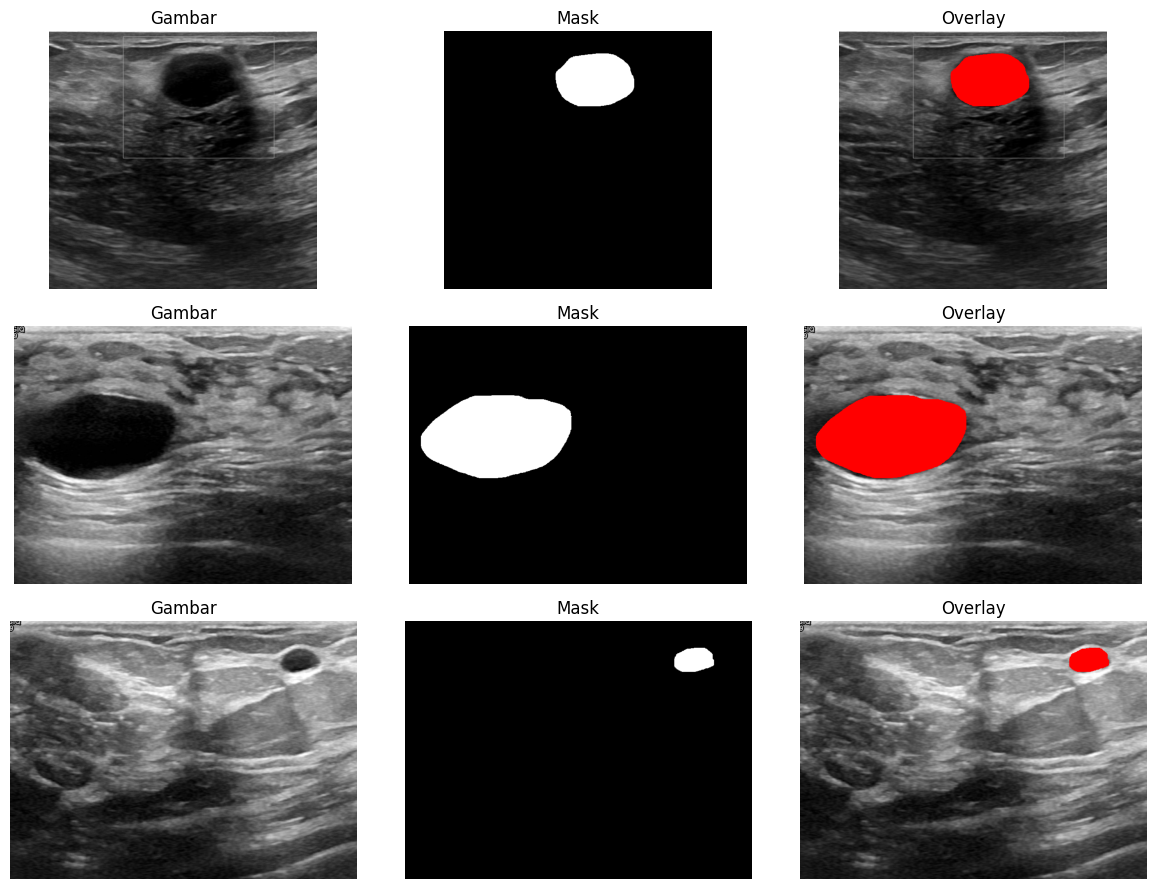

In [ ]:
# Ambil semua path gambar (bukan mask)
image_paths = sorted([p for p in glob('Dataset_BUSI_with_GT/benign/*') if 'mask' not in p])
sample_paths = image_paths[4:7]  # Ambil 3 gambar dari index 4 s.d. 6

plt.figure(figsize=(12, 9))

for idx, img_path in enumerate(sample_paths):
    # Buka gambar
    img = Image.open(img_path).convert("L")  # Grayscale
    img_np = np.array(img)

    # Bangun path mask
    base_name = os.path.basename(img_path).split('.')[0]
    mask_path = img_path.replace(base_name, base_name + '_mask')
    
    # Buka mask jika ada
    if os.path.exists(mask_path):
        mask = Image.open(mask_path).convert("L")
        mask_np = np.array(mask)
    else:
        mask_np = np.zeros_like(img_np)

    # Buat overlay (gambar + mask)
    overlay = np.stack([img_np]*3, axis=-1)  # Konversi ke RGB
    overlay[mask_np > 0] = [255, 0, 0]  # Warnai mask dengan merah

    # Gambar asli
    plt.subplot(3, 3, idx * 3 + 1)
    plt.imshow(img_np, cmap='gray')
    plt.title("Gambar")
    plt.axis('off')

    # Mask
    plt.subplot(3, 3, idx * 3 + 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title("Mask")
    plt.axis('off')

    # Overlay
    plt.subplot(3, 3, idx * 3 + 3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis('off')

plt.tight_layout()
plt.show()


<a id="3.2"></a>
## <span> Loading data </span>

Preprocessing

Grayscale, Resize, Median Blur, CLAHE, Normalisasi, dan Augmentasi(hanya untuk training)


In [ ]:
# import cv2
# import numpy as np
# from glob import glob
# import os

# def load_image(path, size):
#     image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Baca langsung sebagai grayscale
#     image = cv2.resize(image, (size, size))
#     # Denoising dengan median filter
#     image = cv2.medianBlur(image, 3)  # Kernel size 3 (bisa disesuaikan)
#     # Peningkatan kontras dengan CLAHE
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     image = clahe.apply(image)
#     # Normalisasi
#     image = image / 255.0
#     return image

# def load_data(root_path, size):
#     images = []
#     masks = []
#     x = 0  # flag untuk multiple mask
#     for path in sorted(glob(root_path)):
#         img = load_image(path, size)
#         if 'mask' in path:
#             if 'benign' not in os.path.basename(path).lower():
#                 continue  # Skip jika bukan mask benign
#             if x:
#                 masks[-1] += img
#                 # Binarisasi mask setelah penjumlahan
#                 masks[-1] = np.array(masks[-1] > 0.5, dtype='float64')
#             else:
#                 # Binarisasi mask langsung setelah load
#                 masks.append((img > 0.5).astype('float64'))
#                 x = 1
#         else:
#             images.append(img)
#             x = 0
#     return np.array(images), np.array(masks)


# DENGAN AUGMENTASI
# Definisikan transformasi augmentasi (hanya untuk training)
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.3),
])

def load_image(path, size):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (size, size))
    image = cv2.medianBlur(image, 3)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    image = image / 255.0
    return image

def load_data(root_path, size, is_training=False):
    images = []
    masks = []
    x = 0  # flag untuk multiple mask

    for path in sorted(glob(root_path)):
        img = load_image(path, size)
        if 'mask' in path:
            if 'benign' not in os.path.basename(path).lower():
                continue
            if x:
                masks[-1] += img
                masks[-1] = (masks[-1] > 0.5).astype('float64')
            else:
                masks.append((img > 0.5).astype('float64'))
                x = 1
        else:
            images.append(img)
            x = 0

    images = np.array(images)
    masks = np.array(masks)

    # Augmentasi hanya jika mode training
    if is_training:
        aug_images = []
        aug_masks = []
        for img, msk in zip(images, masks):
            augmented = augment(image=img, mask=msk)
            aug_images.append(augmented['image'])
            aug_masks.append(augmented['mask'])
        images = np.array(aug_images)
        masks = np.array(aug_masks)

    # Tambahkan channel axis: (N, H, W, 1)
    images = images[..., np.newaxis]
    masks = masks[..., np.newaxis]

    return images, masks

C:\Users\rizki\AppData\Roaming\Python\Python312\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
C:\Users\rizki\AppData\Local\Temp\ipykernel_16812\3201522601.py:53: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),
C:\Users\rizki\AppData\Roaming\Python\Python312\site-packages\albumentations\core\validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [6]:
# Opsi 1: Semua sebagai keyword argument (disarankan untuk kejelasan)
X, y = load_data(root_path='Dataset_BUSI_with_GT/benign/*', size=128)

# # Opsi 2: Semua sebagai positional argument
# X, y = load_data('Dataset_BUSI_with_GT/benign/*', 250)

# EDA

Data of class benign

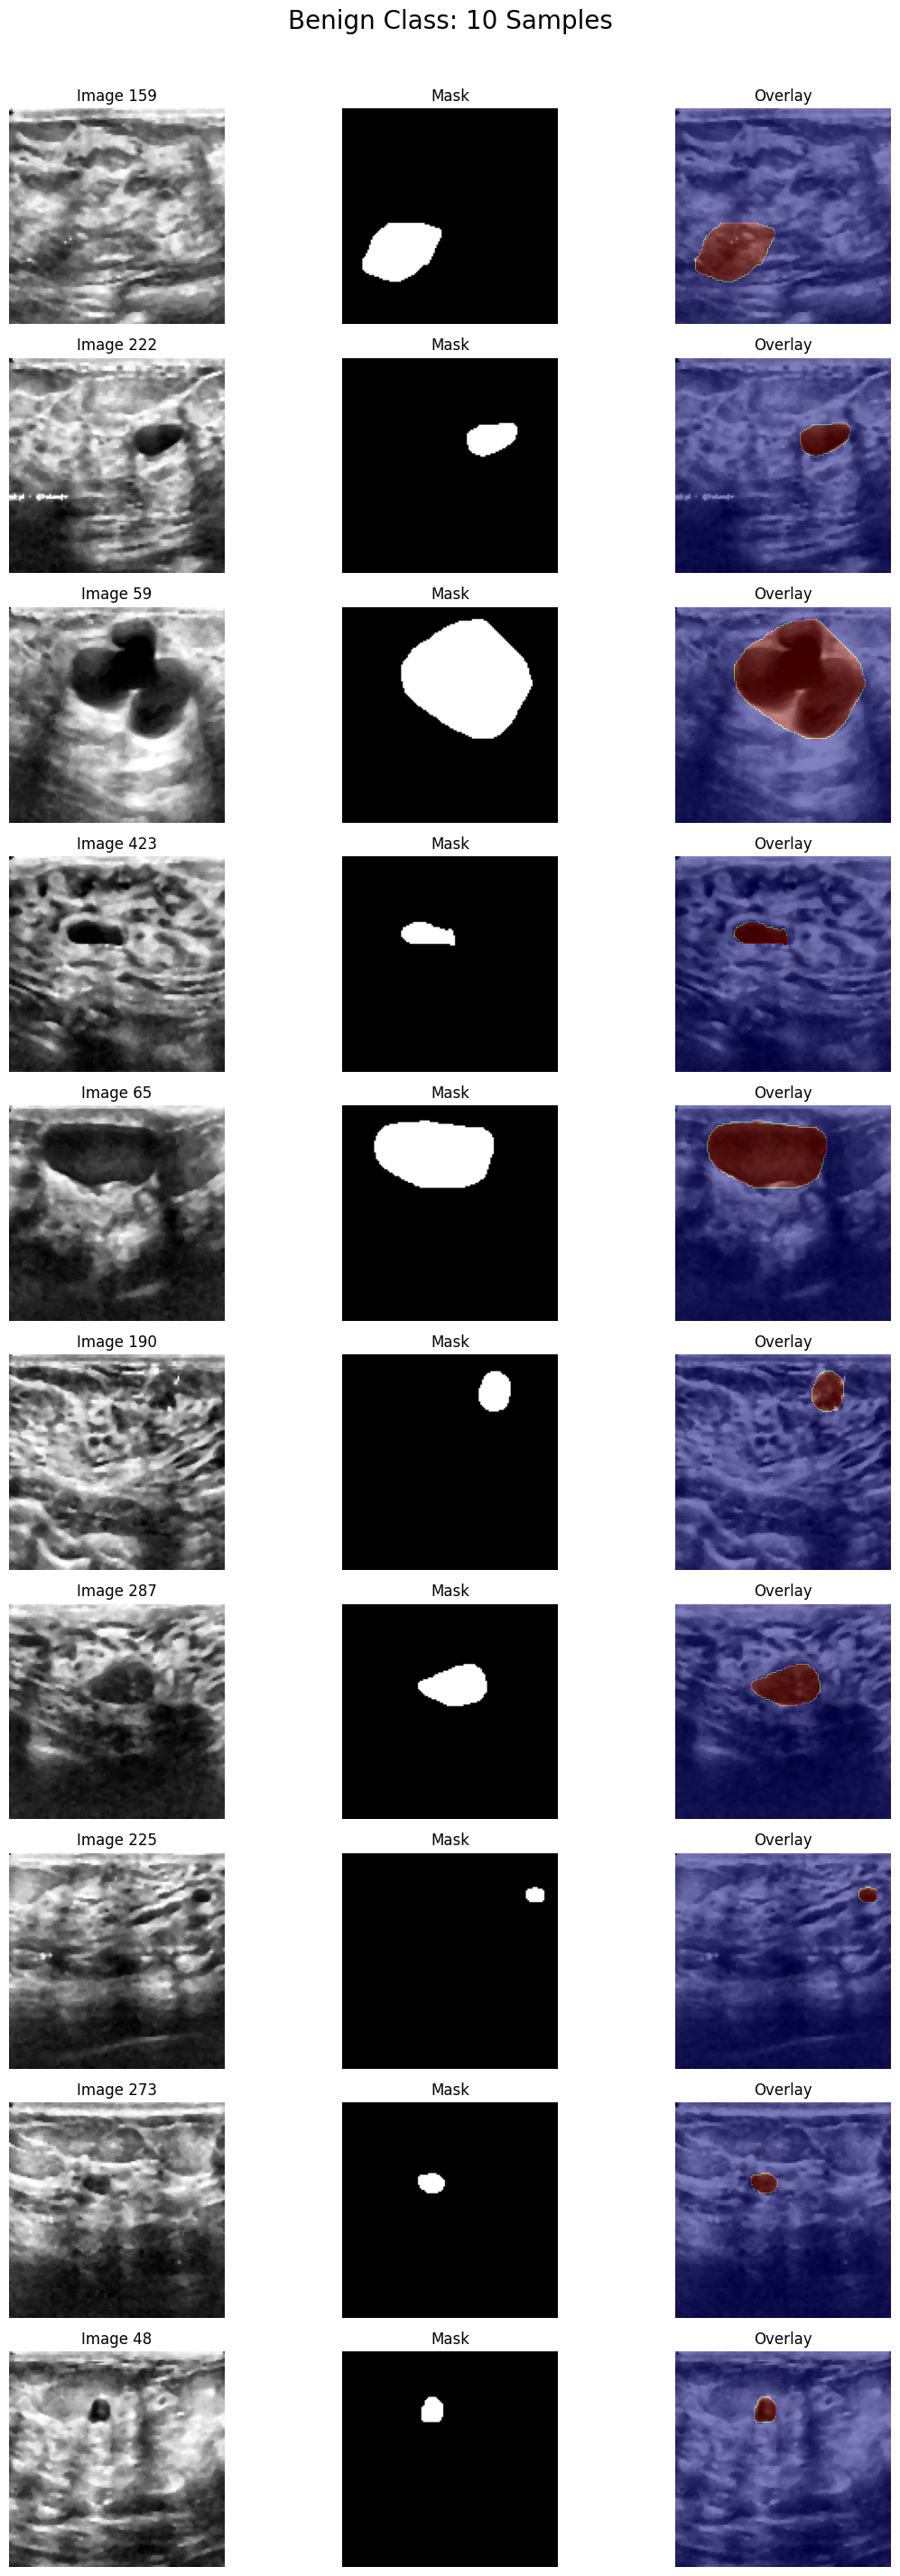

In [ ]:
# Set jumlah gambar
n = 10

fig, ax = plt.subplots(n, 3, figsize=(12, 3 * n))

for i in range(n):
    idx = np.random.randint(len(X))  # Pilih indeks acak dari dataset
    
    ax[i, 0].imshow(X[idx], cmap='gray')
    ax[i, 0].set_title(f'Image {idx}')
    ax[i, 0].axis('off')

    ax[i, 1].imshow(y[idx], cmap='gray')
    ax[i, 1].set_title('Mask')
    ax[i, 1].axis('off')

    ax[i, 2].imshow(X[idx], cmap='gray')
    ax[i, 2].imshow(tf.squeeze(y[idx]), alpha=0.5, cmap='jet')
    ax[i, 2].set_title('Overlay')
    ax[i, 2].axis('off')

fig.suptitle('Benign Class: 10 Samples', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

Visualisasi Distribusi Rata-Rata Mask (Average Mask Visualization)

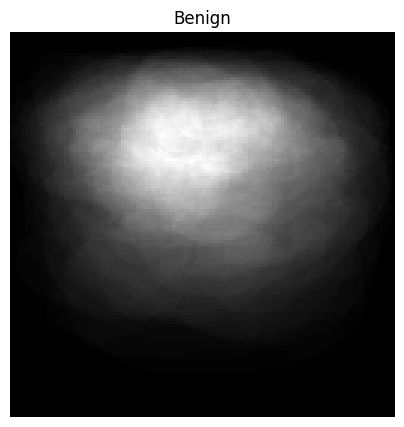

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(sum(y[:437]), cmap='gray')
ax.set_title('Benign')
ax.axis('off')
plt.show()

Prepare data to modeling

In [9]:
# drop normal class because normal class has not mask
X = X[:437]
y = y[:437]

print(f"X shape: {X.shape}     |  y shape: {y.shape}")

# prepare data to modeling
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")

X shape: (437, 128, 128, 1)     |  y shape: (437, 128, 128, 1)

X shape: (437, 128, 128, 1, 1)  |  y shape: (437, 128, 128, 1, 1)


Train-test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print(f'\033[92m')
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)


X_train shape: (393, 128, 128, 1, 1)
y_train shape: (393, 128, 128, 1, 1)
X_test shape: (44, 128, 128, 1, 1)
y_test shape: (44, 128, 128, 1, 1)


# Modeling


Building U-Net Architecture

Conv block

In [11]:
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv

Encoder block

In [12]:
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

Decoder block

In [13]:
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

Build model

In [14]:
def build_model(input_shape):
    input_layer = Input(input_shape)
    
    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    
    model = Model(input_layer, output_layer, name="U-Net")
    return model

size = 128 # atau ukuran lain yang diinginkan
model = build_model(input_shape=(size, size, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

Model plotting

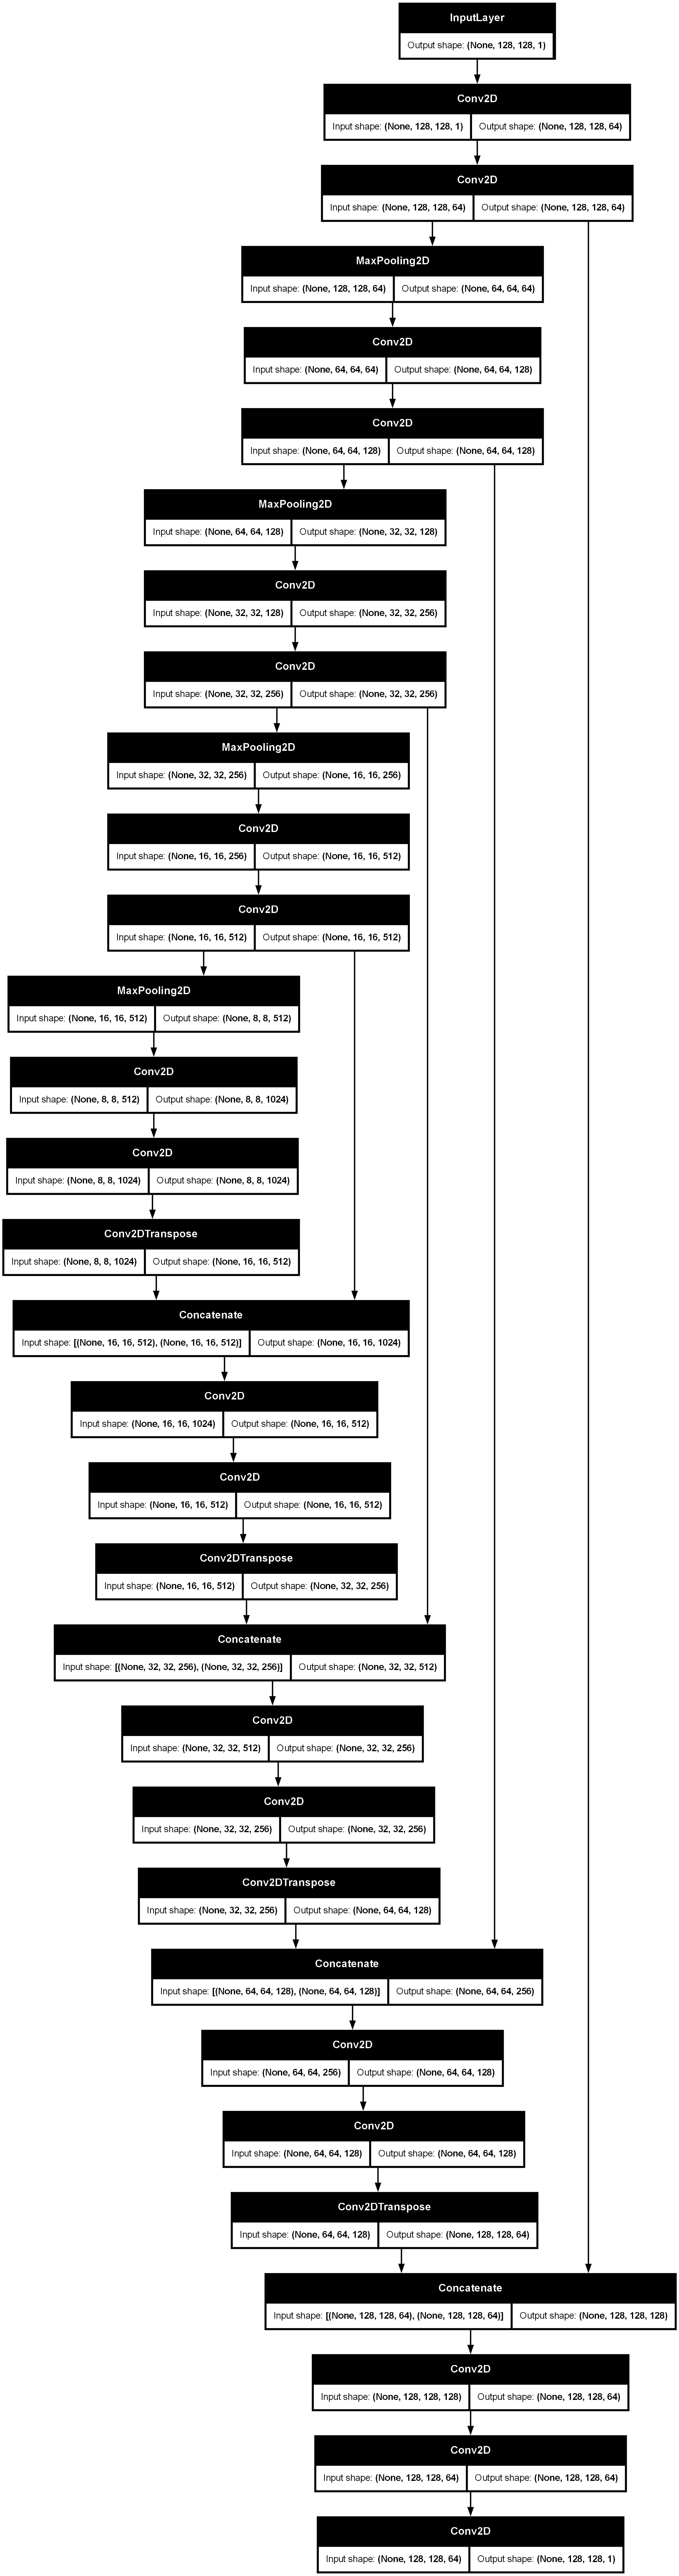

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)
print("Nilai unik pada mask:", np.unique(y_train))

Shape X_train: (393, 128, 128, 1, 1)
Shape y_train: (393, 128, 128, 1, 1)
Nilai unik pada mask: [0. 1.]


Training Model

In [ ]:
# history = model.fit(X_train, y_train, epochs = 10, batch_size=10, validation_data = (X_test,y_test))

# history = model.fit(X_train, y_train, epochs=20, batch_size=10, validation_data=(X_test, y_test))

# history = model.fit(
#     X_train, y_train,
#     epochs=50,
#     batch_size=14,
#     validation_data=(X_test, y_test)
# )


# from keras.callbacks import EarlyStopping, ModelCheckpoint

# callbacks = [
#     EarlyStopping(patience=10, restore_best_weights=True),
#     ModelCheckpoint("unet_benign.keras", save_best_only=True)
# ]

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=100,
#     batch_size=10,
#     callbacks=callbacks
# )

# EARLY STOPING
# from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

# # Callback untuk menampilkan akurasi dalam persen
# class AccuracyAsPercentage(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         acc = logs.get('accuracy')
#         val_acc = logs.get('val_accuracy')
#         if acc is not None and val_acc is not None:
#             print(f"\nEpoch {epoch+1}: Accuracy: {acc*100:.2f}%, Val Accuracy: {val_acc*100:.2f}%")

# # Daftar callbacks
# callbacks = [
#     EarlyStopping(patience=10, restore_best_weights=True),
#     ModelCheckpoint("unet_benign.keras", save_best_only=True),
#     AccuracyAsPercentage()
# ]

# # Training model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=100,
#     batch_size=10,
#     callbacks=callbacks
# )

# TANPA EARLY STOPING
# from keras.callbacks import ModelCheckpoint, Callback

# # Callback to display accuracy as percentage
# class AccuracyAsPercentage(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         acc = logs.get('accuracy')
#         val_acc = logs.get('val_accuracy')
#         if acc is not None and val_acc is not None:
#             print(f"\nEpoch {epoch+1}: Accuracy: {acc*100:.2f}%, Val Accuracy: {val_acc*100:.2f}%")

# # Optional: Add ReduceLROnPlateau for dynamic learning rate adjustment
# from keras.callbacks import ReduceLROnPlateau
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# # Callbacks list without EarlyStopping
# callbacks = [
#     ModelCheckpoint("unet_benign.keras", save_best_only=True),
#     AccuracyAsPercentage(),
#     reduce_lr
# ]

# # Training model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=50,
#     batch_size=8,
#     callbacks=callbacks
# )


# DENGAN EARLY STOPING DAN AUGMENTASI
# Callback custom: tampilkan akurasi dalam persen
class AccuracyAsPercentage(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if acc is not None and val_acc is not None:
            print(f"\nEpoch {epoch+1}: Accuracy: {acc*100:.2f}%, Val Accuracy: {val_acc*100:.2f}%")

# Reduce learning rate jika val_loss stagnan
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Early stopping untuk menghentikan training jika overfitting mulai terjadi
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

# Save model terbaik berdasarkan val_loss
model_ckpt = ModelCheckpoint(
    "model_checkpoint_unet.keras",  # ubah nama
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


# Gabung semua callback
callbacks = [
    model_ckpt,
    AccuracyAsPercentage(),
    reduce_lr,
    early_stop
]

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,
    callbacks=callbacks
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8560 - loss: 0.4164
Epoch 1: val_loss improved from inf to 0.32001, saving model to model_checkpoint_unet.keras

Epoch 1: Accuracy: 90.95%, Val Accuracy: 92.28%
50/50 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.8570 - loss: 0.4147 - val_accuracy: 0.9228 - val_loss: 0.3200 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9360 - loss: 0.2546
Epoch 2: val_loss improved from 0.32001 to 0.28686, saving model to model_checkpoint_unet.keras

Epoch 2: Accuracy: 93.21%, Val Accuracy: 92.28%
50/50 ━━━━━━━━━━━━━━━━━━━━ 225s 5s/step - accuracy: 0.9359 - loss: 0.2547 - val_accuracy: 0.9228 - val_loss: 0.2869 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9320 - loss: 0.2395
Epoch 3: val_loss improved from 0.28686 to 0.28377, saving model to model_checkpoint_unet.keras

Epoch 3: Accuracy: 93.00%, Val Accuracy: 92.28%
50/50 ━━━━━━━━━━━━━━━━━━━━ 363s 7s/step 

Hasil Testing Model

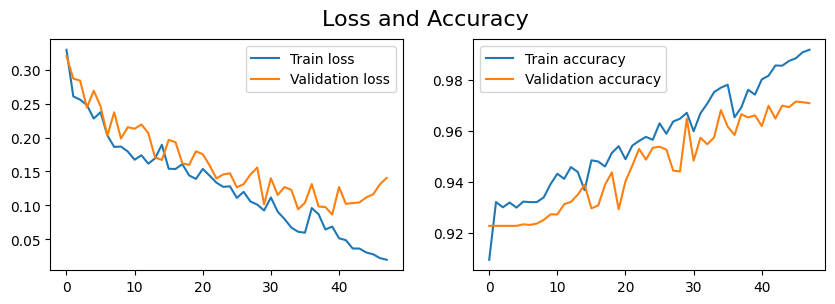

In [64]:
# Visualisasi loss dan akurasi (tidak berubah)
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

Testing Model (Citra Segmentasi)

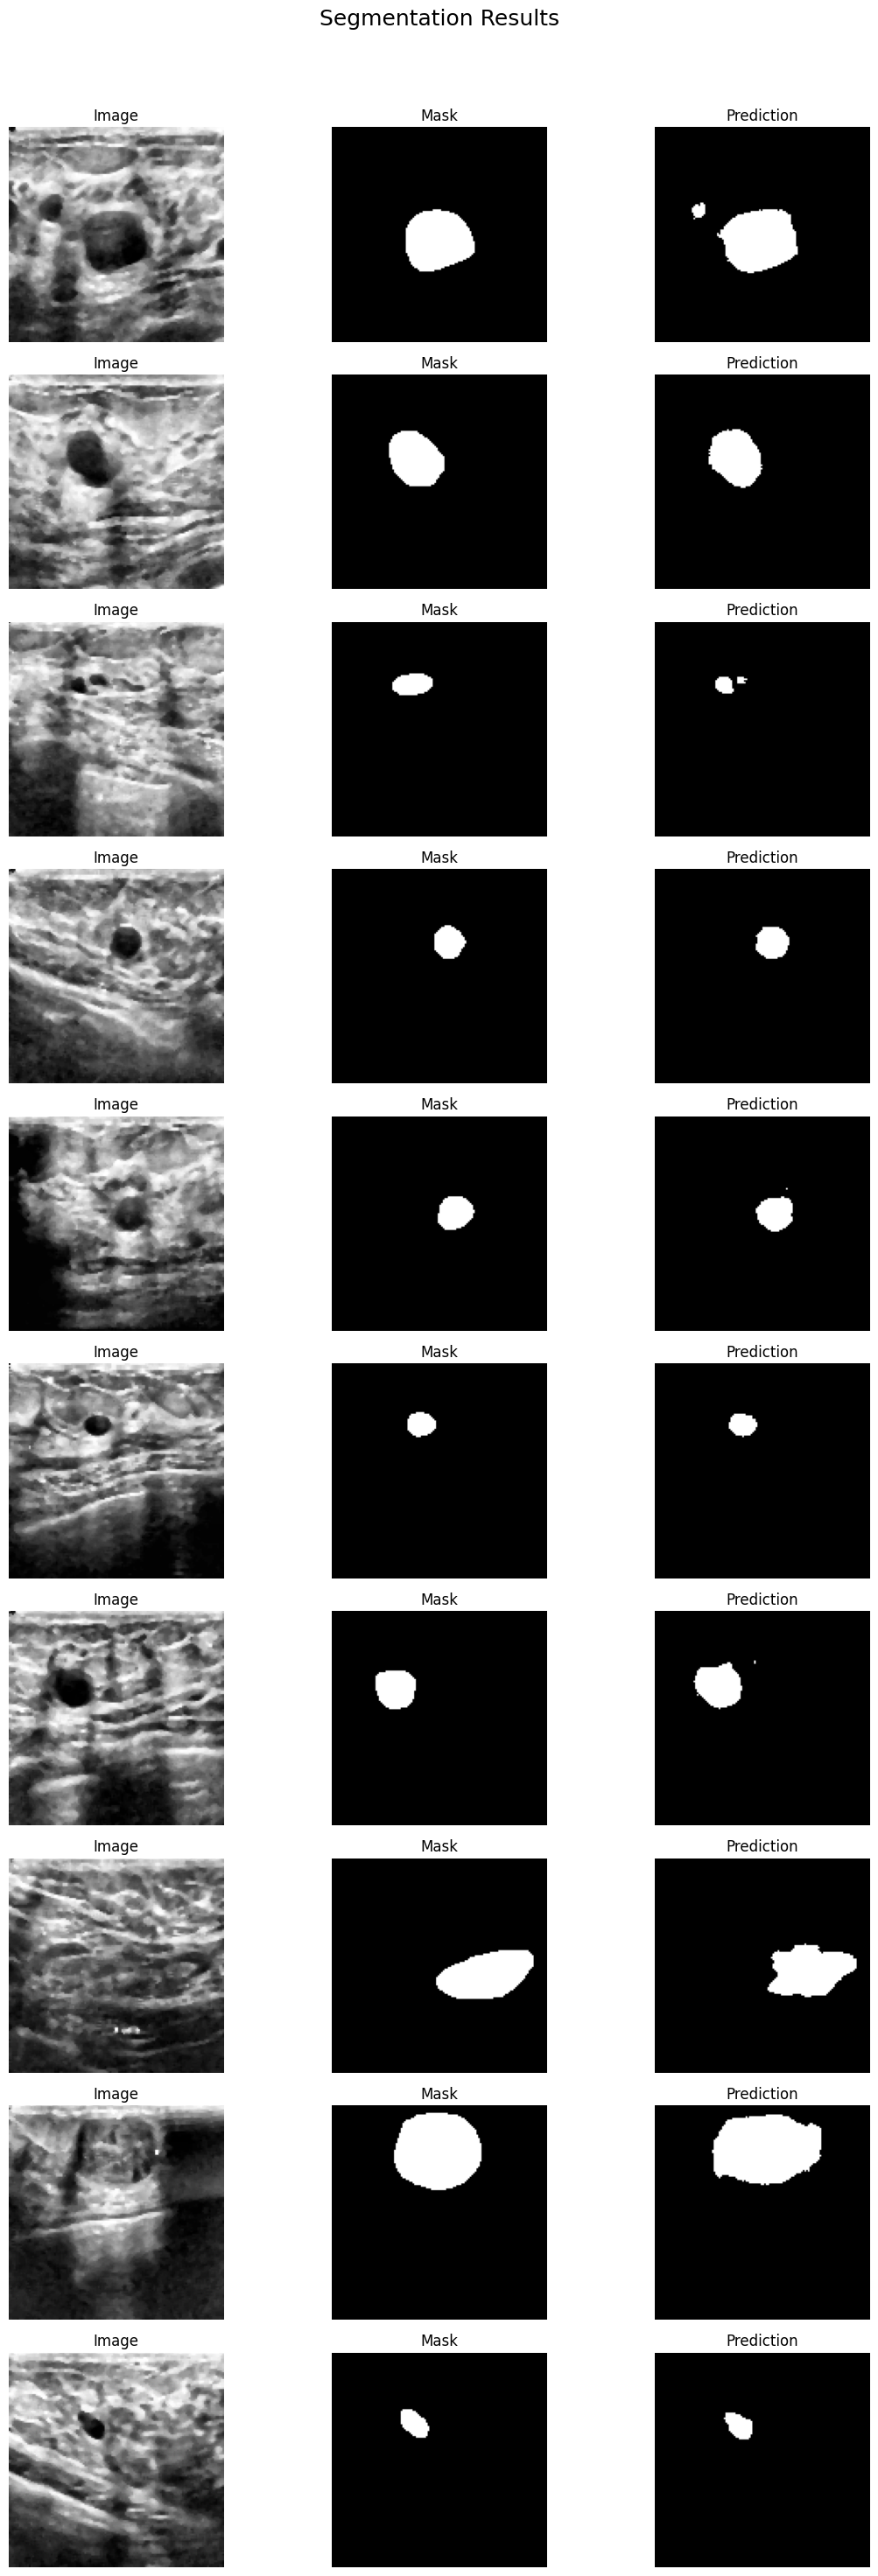

In [ ]:
# Visualisasi hasil segmentasi 10 gambar
fig, ax = plt.subplots(10, 3, figsize=(12, 30))  # 10 baris, 3 kolom

# Pilih 10 indeks acak dari dataset test
indices = np.random.choice(X_test.shape[0], 10, replace=False)

for i, idx in enumerate(indices):
    ax[i, 0].imshow(X_test[idx].squeeze(), cmap='gray')
    ax[i, 0].set_title('Image')
    ax[i, 0].axis('off')
    
    ax[i, 1].imshow(y_test[idx].squeeze(), cmap='gray')
    ax[i, 1].set_title('Mask')
    ax[i, 1].axis('off')
    
    pred_mask = model.predict(np.expand_dims(X_test[idx], 0), verbose=0)[0]
    ax[i, 2].imshow(pred_mask.squeeze() > 0.5, cmap='gray')
    ax[i, 2].set_title('Prediction')
    ax[i, 2].axis('off')

fig.suptitle('Segmentation Results', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # beri margin atas untuk judul
plt.show()

Evaluasi Model

In [ ]:
accuracies = []

for i in range(X_test.shape[0]):
    # Prediksi untuk 1 gambar
    pred_mask = model.predict(np.expand_dims(X_test[i], 0), verbose=0)[0].squeeze()
    
    # Threshold jadi binary mask
    pred_binary = (pred_mask > 0.5).astype(np.uint8)
    
    # Ground truth binary
    true_mask = (y_test[i].squeeze() > 0.5).astype(np.uint8)
    
    # Hitung akurasi pixel-wise
    acc = accuracy_score(true_mask.flatten(), pred_binary.flatten())
    accuracies.append(acc)

mean_accuracy = np.mean(accuracies)
print(f"Mean accuracy on test set: {mean_accuracy:.4f}")

# Fungsi Dice Loss dan Dice Coefficient
def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

def dice_loss(y_true, y_pred, smooth=1):
    return 1 - dice_coef(y_true, y_pred, smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

# Kompilasi ulang model dengan loss gabungan
model.compile(
    loss=bce_dice_loss,
    optimizer="adam",
    metrics=[dice_coef]
)

# Prediksi dari model
y_pred = model.predict(X_test, verbose=0)

# Squeeze channel terakhir jika shape[−1]==1
if y_pred.shape[-1] == 1:
    y_pred = np.squeeze(y_pred, axis=-1)
if y_test.shape[-1] == 1:
    y_test = np.squeeze(y_test, axis=-1)

# Threshold prediksi dan true mask jadi biner 0/1
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)
y_true = (y_test > 0.5).astype(np.uint8)

# Flatten untuk metrik yang butuh 1D array
y_true_flat = y_true.flatten()
y_pred_flat = y_pred_thresholded.flatten()

# Hitung Mean IoU
iou_metric = MeanIoU(num_classes=2)
iou_metric.update_state(y_true_flat, y_pred_flat)
print("Mean IoU = %.3f" % iou_metric.result().numpy())

# Hitung Precision
precision = Precision()
precision.update_state(y_true_flat, y_pred_flat)
p = precision.result().numpy()
print("Precision Score = %.3f" % p)

# Hitung Recall
recall = Recall()
recall.update_state(y_true_flat, y_pred_flat)
r = recall.result().numpy()
print("Recall Score = %.3f" % r)

# Hitung F1 Score manual
f1_score = 2 * (p * r) / (p + r + 1e-7)
print("F1 Score = %.3f" % f1_score)

# Hitung Dice Coefficient
# Konversi ke tensor dan pastikan shape sama (batch, H, W, 1)
y_true_tf = tf.convert_to_tensor(y_true, dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_thresholded, dtype=tf.float32)

if len(y_true_tf.shape) == 3:
    y_true_tf = tf.expand_dims(y_true_tf, axis=-1)
if len(y_pred_tf.shape) == 3:
    y_pred_tf = tf.expand_dims(y_pred_tf, axis=-1)

dice = dice_coef(y_true_tf, y_pred_tf).numpy()
print("Dice Coefficient = %.3f" % dice)


Mean accuracy on test set: 0.9660
Mean IoU = 0.798
Precision Score = 0.796
Recall Score = 0.753
F1 Score = 0.774
Dice Coefficient = 0.774


Perbandingan dengan K-Means dari 10 terbaik (IoU tinggi)

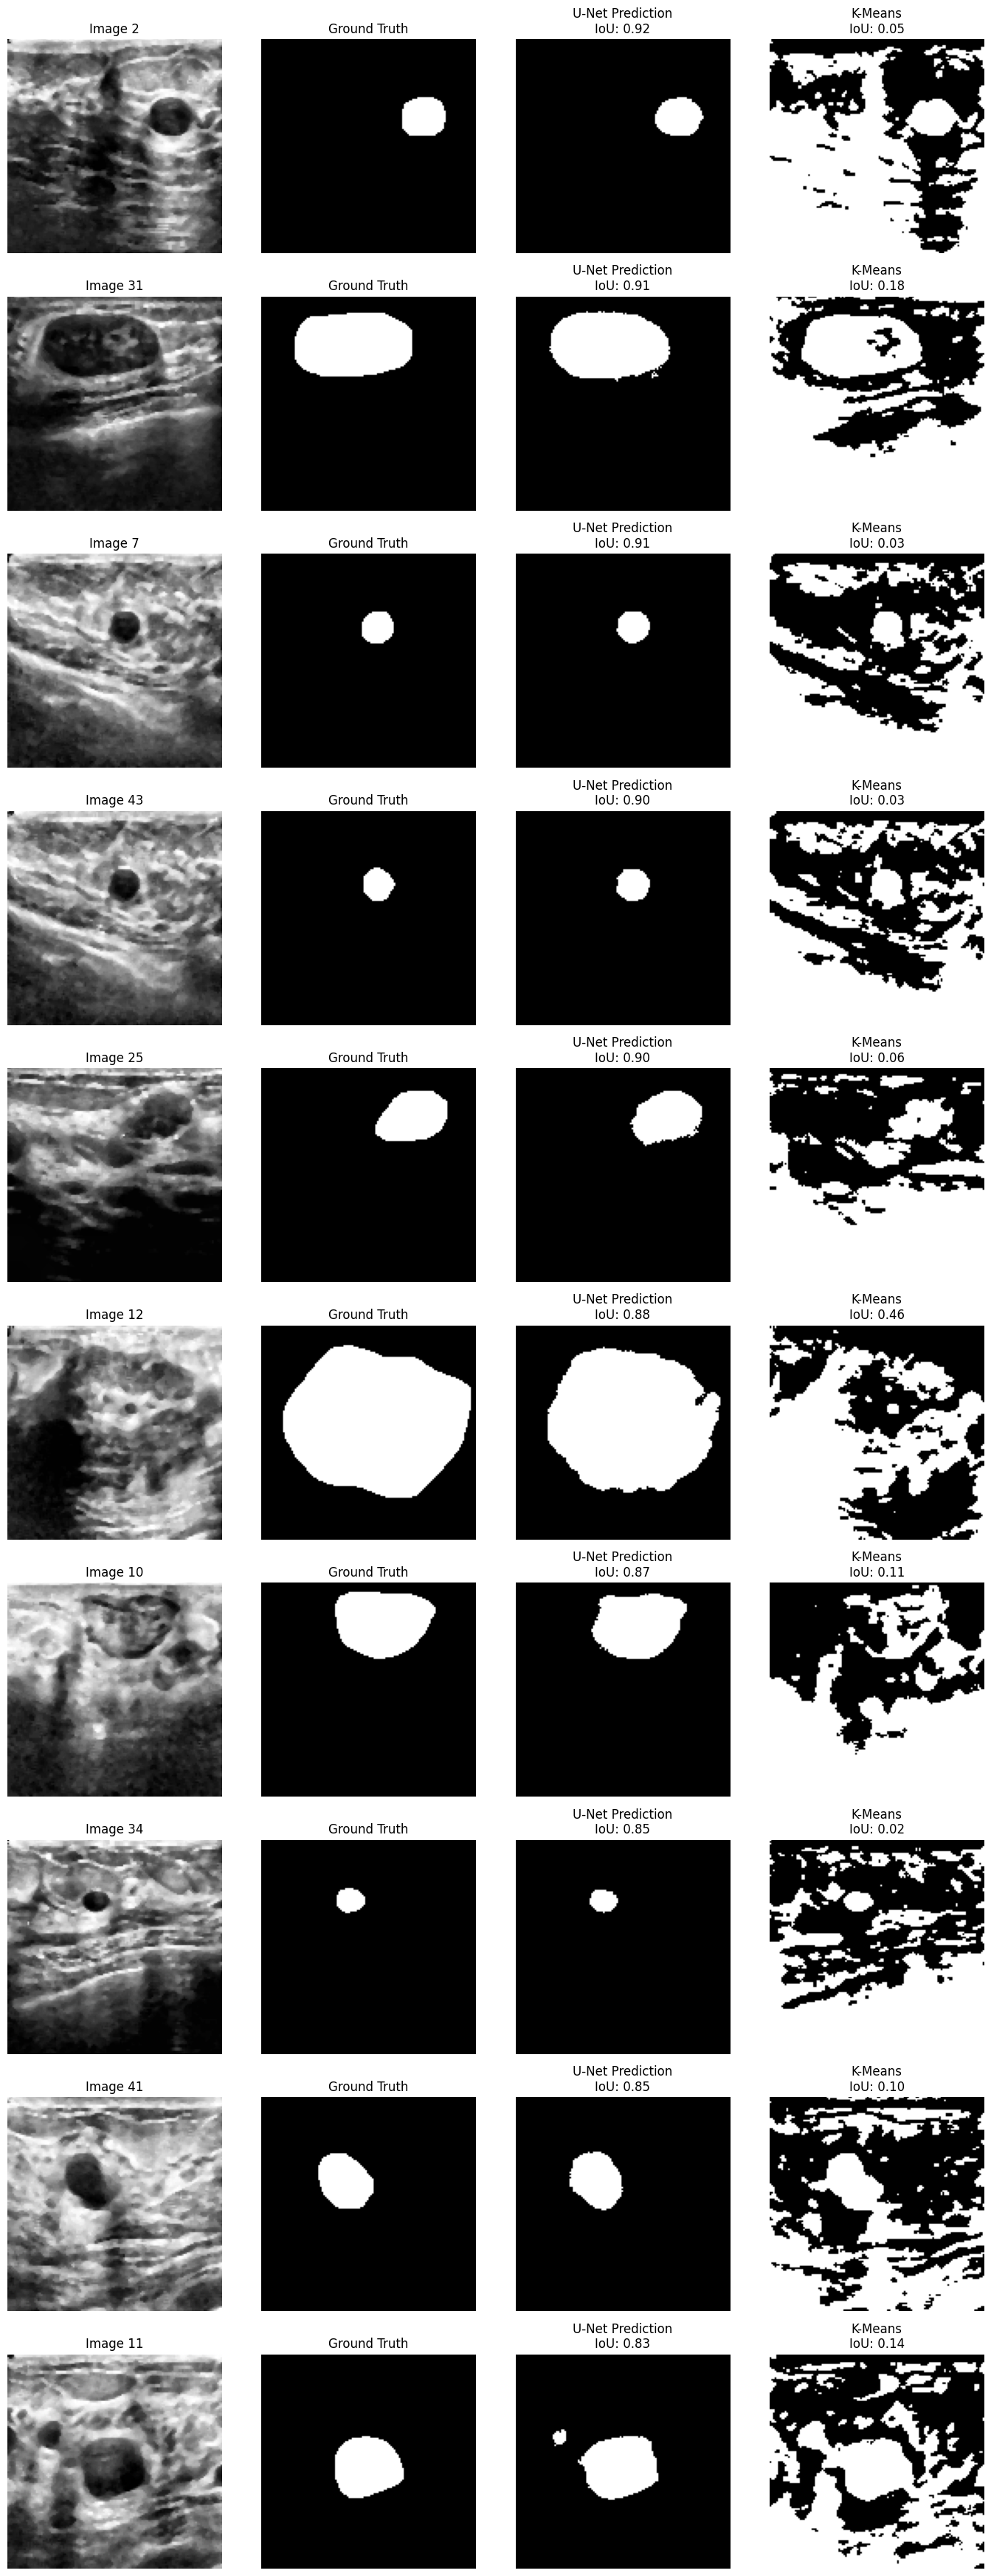

In [ ]:
# Fungsi K-Means segmentasi (grayscale image)
def kmeans_segmentation(image, n_clusters=2):
    Z = image.reshape((-1, 1))
    Z = np.float32(Z)
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
    kmeans.fit(Z)
    labels = kmeans.labels_.reshape(image.shape)

    # Cari cluster dengan mean intensitas terendah (diasumsikan lesi)
    cluster_means = [Z[kmeans.labels_ == i].mean() for i in range(n_clusters)]
    lesion_cluster = np.argmin(cluster_means)

    # Buat binary mask: 1 = lesi, 0 = background
    mask = (labels == lesion_cluster).astype(np.uint8)
    return mask

# Fungsi hitung IoU
def compute_iou(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    return intersection / union

ious_unet = []
ious_kmeans = []

for i in range(X_test.shape[0]):
    img = X_test[i].squeeze()
    true_mask = y_test[i].squeeze()

    # Prediksi U-Net
    pred_unet = model.predict(np.expand_dims(X_test[i], 0), verbose=0)[0].squeeze()
    binary_unet = (pred_unet > 0.5).astype(np.uint8)
    iou_u = compute_iou(true_mask, binary_unet)
    ious_unet.append(iou_u)

    # Prediksi K-Means
    pred_kmeans = kmeans_segmentation(img)
    iou_k = compute_iou(true_mask, pred_kmeans)
    ious_kmeans.append(iou_k)

ious_unet = np.array(ious_unet)
ious_kmeans = np.array(ious_kmeans)

# 10 gambar terbaik berdasarkan IoU U-Net
top_indices = np.argsort(ious_unet)[-10:][::-1]

# Visualisasi
fig, ax = plt.subplots(10, 4, figsize=(14, 35))

for i, idx in enumerate(top_indices):
    img = X_test[idx].squeeze()
    mask = y_test[idx].squeeze()
    pred_unet = model.predict(np.expand_dims(X_test[idx], 0), verbose=0)[0].squeeze()
    binary_unet = (pred_unet > 0.5).astype(np.uint8)
    pred_kmeans = kmeans_segmentation(img)

    ax[i, 0].imshow(img, cmap='gray')
    ax[i, 0].set_title(f"Image {idx}")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(mask, cmap='gray')
    ax[i, 1].set_title("Ground Truth")
    ax[i, 1].axis("off")

    ax[i, 2].imshow(binary_unet, cmap='gray')
    ax[i, 2].set_title(f"U-Net Prediction\nIoU: {ious_unet[idx]:.2f}")
    ax[i, 2].axis("off")

    ax[i, 3].imshow(pred_kmeans, cmap='gray')
    ax[i, 3].set_title(f"K-Means\nIoU: {ious_kmeans[idx]:.2f}")
    ax[i, 3].axis("off")

plt.tight_layout()
plt.show()

Evaluasi KMeans Model

In [ ]:
# Fungsi K-Means segmentasi (grayscale image)
def kmeans_segmentation(image, n_clusters=2):
    Z = image.reshape((-1, 1))
    Z = np.float32(Z)
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
    kmeans.fit(Z)
    labels = kmeans.labels_.reshape(image.shape)

    # Cari cluster dengan mean intensitas terendah (diasumsikan lesi)
    cluster_means = [Z[kmeans.labels_ == i].mean() for i in range(n_clusters)]
    lesion_cluster = np.argmin(cluster_means)

    # Buat binary mask: 1 = lesi, 0 = background
    mask = (labels == lesion_cluster).astype(np.uint8)
    return mask

# Fungsi hitung IoU
def compute_iou(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    return intersection / union

# Fungsi hitung Dice Coefficient
def compute_dice(y_true, y_pred, smooth=1):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    return (2 * intersection + smooth) / (y_true.sum() + y_pred.sum() + smooth)

# Fungsi hitung Accuracy
def compute_accuracy(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    correct = np.sum(y_true == y_pred)
    total = y_true.size
    return correct / total

# Fungsi hitung Precision
def compute_precision(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    tp = np.logical_and(y_pred, y_true).sum()
    fp = np.logical_and(y_pred, np.logical_not(y_true)).sum()
    if (tp + fp) == 0:
        return 0.0
    return tp / (tp + fp)

# Fungsi hitung Recall
def compute_recall(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    tp = np.logical_and(y_pred, y_true).sum()
    fn = np.logical_and(np.logical_not(y_pred), y_true).sum()
    if (tp + fn) == 0:
        return 0.0
    return tp / (tp + fn)

# Fungsi hitung F1 Score
def compute_f1(precision, recall):
    if (precision + recall) == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

# List untuk simpan metrik
accuracies = []
ious = []
dices = []
precisions = []
recalls = []
f1_scores = []

for i in range(X_test.shape[0]):
    img = X_test[i].squeeze()
    true_mask = y_test[i].squeeze()

    pred_mask = kmeans_segmentation(img)

    accuracies.append(compute_accuracy(true_mask, pred_mask))
    ious.append(compute_iou(true_mask, pred_mask))
    dices.append(compute_dice(true_mask, pred_mask))
    precision = compute_precision(true_mask, pred_mask)
    recall = compute_recall(true_mask, pred_mask)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(compute_f1(precision, recall))

print(f"Mean Accuracy (K-Means): {np.mean(accuracies):.4f}")
print(f"Mean IoU (K-Means): {np.mean(ious):.4f}")
print(f"Mean Dice Coefficient (K-Means): {np.mean(dices):.4f}")
print(f"Mean Precision (K-Means): {np.mean(precisions):.4f}")
print(f"Mean Recall (K-Means): {np.mean(recalls):.4f}")
print(f"Mean F1 Score (K-Means): {np.mean(f1_scores):.4f}")

Mean Accuracy (K-Means): 0.4724
Mean IoU (K-Means): 0.0827
Mean Dice Coefficient (K-Means): 0.1430
Mean Precision (K-Means): 0.0894
Mean Recall (K-Means): 0.7371
Mean F1 Score (K-Means): 0.1429


# Analis dan Kesimpulan

| Metrik         | Fungsi                                                             |
| -------------- | ------------------------------------------------------------------ |
| **IoU**        | Seberapa besar tumpang tindih prediksi vs. label sebenarnya        |
| **Precision**  | Dari semua prediksi positif, berapa yang benar-benar positif       |
| **Recall**     | Dari semua yang seharusnya positif, berapa yang berhasil ditemukan |
| **F1 Score**   | Harmonis antara precision dan recall                               |
| **Dice Coef.** | Sangat umum di medis, mirip dengan F1 tetapi digunakan di piksel   |



**1. Evaluasi Kinerja Model**
| Metode      | Mean Accuracy | Mean IoU  | Dice Coefficient | Precision | Recall     | F1 Score |
| ----------- | ------------- | --------- | ---------------- | --------- | ---------- | -------- |
| **U-Net**   | **0.9660**    | **0.798** | **0.774**        | 0.796     | 0.753      | 0.774    |
| **K-Means** | 0.4724        | 0.0827    | 0.143            | 0.0894    | **0.7371** | 0.1429   |

Akurasi, IoU, dan Dice Coefficient U-Net jauh lebih tinggi dibandingkan K-Means, menunjukkan bahwa U-Net sangat unggul dalam segmentasi area lesi yang relevan.

K-Means memiliki recall yang tinggi (0.7371), yang berarti metode ini cenderung menangkap banyak area lesi, namun dengan precision yang sangat rendah (0.0894), menunjukkan bahwa sebagian besar prediksi lesi oleh K-Means adalah false positive (salah segmentasi).

Nilai F1 Score K-Means juga sangat rendah, mencerminkan keseimbangan precision dan recall yang buruk.

**2. Visualisasi dan Kualitas Prediksi**
Dari hasil visual yang diberikan:

U-Net memberikan segmentasi yang bersih, halus, dan sesuai bentuk ground truth, dengan nilai IoU konsisten di atas 0.8 dalam sebagian besar kasus.

K-Means menghasilkan segmentasi yang sangat bising, dengan prediksi tersebar dan tidak menyerupai bentuk lesi asli.

Pada citra dengan lesi yang lebih besar atau lebih jelas, U-Net tetap akurat, sedangkan K-Means tidak menunjukkan peningkatan yang signifikan.

**3. Learning Curve**
Grafik loss dan akurasi menunjukkan kinerja training dan validation U-Net yang stabil dan meningkat seiring epoch.

Validation accuracy mencapai lebih dari 0.96, menunjukkan bahwa model generalisasi dengan baik ke data yang belum pernah dilihat.

Tidak terjadi overfitting signifikan, karena perbedaan antara training dan validation relatif kecil.

**Kesimpulan**
U-Net secara signifikan lebih unggul dibandingkan K-Means dalam tugas segmentasi lesi kanker payudara pada citra USG.

Performa kuantitatif U-Net menunjukkan nilai IoU dan Dice Coefficient yang mendekati 0.8, menandakan segmentasi yang sangat mendekati ground truth.

K-Means tidak cocok untuk segmentasi medis kompleks karena hasil segmentasinya sangat bising dan kurang presisi, walaupun recall tinggi.

U-Net lebih konsisten dan dapat diandalkan, cocok untuk digunakan dalam sistem pendukung diagnosis berbasis citra medis, khususnya dalam mendeteksi lesi jinak/kanker pada USG payudara.

Kinerja U-Net menunjukkan bahwa pendekatan deep learning dengan arsitektur khusus seperti U-Net lebih efektif daripada metode clustering konvensional untuk segmentasi medis.